# Exploratory Spatial Data Analysis of Disaster-Tweets

With this notebook, you can analyse tweets that are related to two natural disasters.  
How are they related? They were posted in the impacted area of the disaster and posted after the disaster occurred.  
How can we extract information from this dataset? We analyse the spatial and temporal dimension of the dataset by comparing disaster-related tweets with the dataset. 

Datasets are located in '../tweets'.  
Two Datasets:
* Napa Earthquake tweets -> https://en.wikipedia.org/wiki/2014_South_Napa_earthquake
* Hurricane Harvey tweets -> https://en.wikipedia.org/wiki/Hurricane_Harvey

### Assignment

Create a new markdown and a code cell to answer the following questions:

* How many tweets are in the dataset?
* What words are the most frequent words in the wordcloud (related to the size of the words)?
* Perform  topic modelling with and without preprecessing. What could you observe?
* Which topics could you identify in the datasets? Can you label some of the topics?
* What is the min and max date of the dataset?
* How does the time-series of the disaster-related topic and the overall dataset differ?
* How does the heatmap of the disaster-related topic and the overall dataset differ?

Hint: You do not have to program somehting by yourself, but you have to understand the code (change some variables) and look for the answers of the questions.


## Load dataset and libraries

In [204]:
%matplotlib inline

In [205]:
from preprocessing import *
import gensim
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium

In [206]:
df = pd.read_csv('../tweets/napa_tweets.csv', sep=',', error_bad_lines=False, index_col=False, warn_bad_lines=False)
#df = pd.read_csv('Ressources_and_Results/hurricane_harvey_tweets.csv', sep=',', error_bad_lines=False, index_col=False, warn_bad_lines=False,encoding='utf8', header=0)
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)

id              time                                  tweet_text  \
0   0  24.08.2014 23:07                             SMITE vs LOL ??   
1   1  24.08.2014 23:12  Random people complimenting you is so nice   
2   2  24.08.2014 23:37                  Calum is being an annoying   
3   3  24.08.2014 23:38                                      Plan B   
4   4  24.08.2014 23:42                              Laaawwwwllllll   

    latitude   longitude  
0  37.600700 -122.014820  
1  38.417359 -122.709612  
2  37.353794 -121.863898  
3  37.957866 -122.032392  
4  38.338400 -122.685784

In [207]:
df.shape

(90907, 5)

## Natural language processing

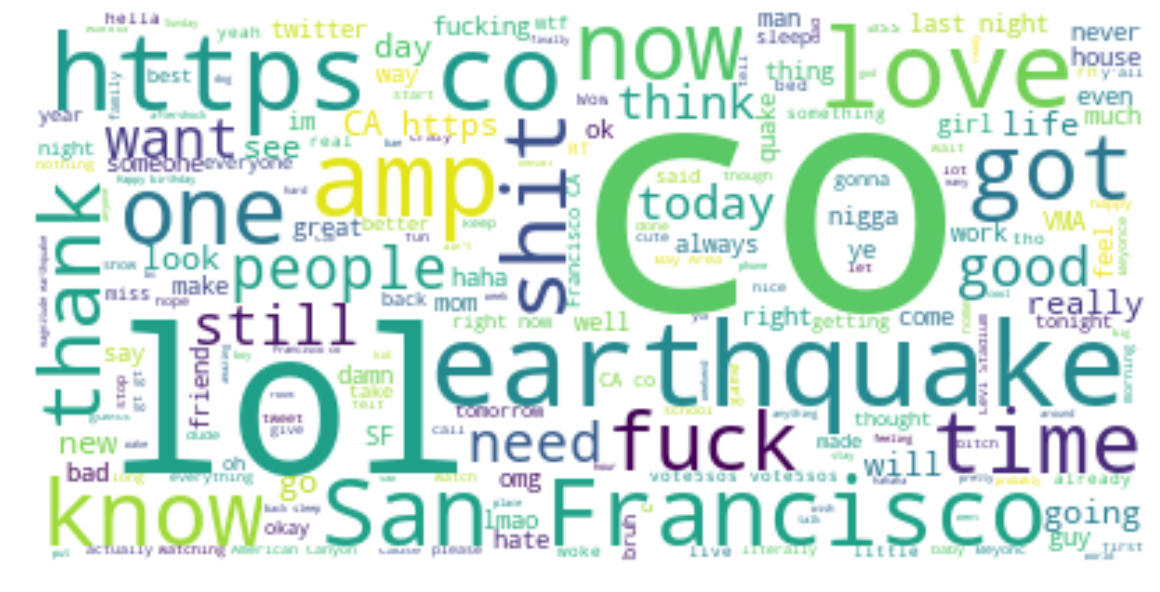

In [208]:
wordcloud = WordCloud(background_color='white').generate(' '.join(df['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [225]:
?WordCloud

Download nltk Ressources.

In [210]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Clemens
[nltk_data]     Havas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Clemens
[nltk_data]     Havas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Transform tweets text into usable format

In [211]:
#tweets' text as list
tweets_text = df['tweet_text'].tolist()
#lowercase
tweets_text=[tweet.lower() for tweet in tweets_text]

#remove URLs
remove_url_regex = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'
tweets_text = filter_tweets_before_tokenization(tweets_text, remove_url_regex)

#tokenization
tweets_text=[nltk.word_tokenize(tweet) for tweet in tweets_text]

In [212]:
tweets_text

[['smite', 'vs', 'lol', '?', '?'],
 ['random', 'people', 'complimenting', 'you', 'is', 'so', 'nice'],
 ['calum', 'is', 'being', 'an', 'annoying'],
 ['plan', 'b'],
 ['laaawwwwllllll'],
 ['d2b', '?', '?', 'lol'],
 ['6.0', 'earthquake', '?', '?', '?', '?', '?', '?'],
 ['stits', 'about', 'to', 'go', 'down'],
 ['1', 'time'],
 ['@', 'adhesiveproduct', 'hey', '?', '?'],
 ['but', 'fun', 'night'],
 ['ig', ':', 'ganksee'],
 ['you', "'re", 'my', 'downfall', '.'],
 ['@', 'skwabble', 'you', 'know', 'how', 'i', 'know', 'your', 'lying'],
 ['&', 'gt', ';', ':', '/'],
 ['@', 'sayedlivestkd', 'oh', 'hoo'],
 ['waiting..'],
 ['wowwwwwwwwww'],
 ['anxiety',
  'gets',
  'the',
  'best',
  'of',
  'me',
  '&',
  'amp',
  ';',
  'it',
  'fucking',
  'sucks',
  '.'],
 ['holy', 'fuck', 'its', '3'],
 ['it', 'scared', 'my', 'little', 'cat'],
 ['holy', 'earthquake', '.'],
 ['rumble'],
 ['@', 'mariannaandreev', 'crazy', '!', 'and', 'welcome', 'back', ':', ')'],
 ['i', "'m", 'so', 'scared', 'i', 'want', 'to', 'throw'

### Text preprocessing

Test multiple preprocessing procedures and observe their impact on the analysis results

In [213]:
#remove special characters
remove_sc_regex = r'[^A-Za-z ]+'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_sc_regex)

# remove short words
remove_short_words_regex = r'\W*\b\w{1,3}\b'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_short_words_regex)

# Remove all user names in the tweet text
user_names_regex = r"@\S+"
tweets_text = filter_tweets_after_tokenization(tweets_text,user_names_regex)

#increase keyword frequency by aggregating similar keywords
# check the order if preprocessing routine! e.g. stemming would effect the performance of synonym handling
#disaster = 'hurrican'
#disaster_terms = ['hurricane', 'hurricaneharvey', 'hurricane_harvey', 'flood', 'storm']
#tweets_text = synonym_handling(tweets_text, disaster, disaster_terms)

#Remove unique words that appear only once in the dataset
frequency = getFrequency(tweets_text)
min_frequency_words = 2
tweets_text = [[token for token in tweet if frequency[token] > min_frequency_words] for tweet in tweets_text]

# Remove stop words
# You need to download the stopwords
from nltk.corpus import PlaintextCorpusReader
stoplist = set(stopwords.words('english'))
tweets_text = [[word for word in document if word not in stoplist] for document in tweets_text]

#Stemming
stemmer = PorterStemmer()
#stemmer = SnowballStemmer("english")
tweets_text = [[stemmer.stem(word) for word in sub_list] for sub_list in tweets_text]

#remove empty strings
tweets_text = [[word for word in document if word] for document in tweets_text]

tweets_text[:10]

[[],
 ['random', 'peopl', 'nice'],
 ['calum', 'annoy'],
 ['plan'],
 [],
 [],
 ['earthquak'],
 [],
 ['time'],
 []]

Create corpus and dictionary for LDA

In [214]:
dict = gensim.corpora.Dictionary(tweets_text)
corpus = [dict.doc2bow(text) for text in tweets_text]

Train Model

In [215]:
num_topics= 10
alpha = 0.0001
eta= 0.0001
passes = 10
lda = gensim.models.LdaMulticore(corpus, id2word=dict, num_topics= num_topics, alpha = alpha, eta= eta, passes = passes)

D:\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Show top words of topics

In [216]:
top_words = 5

#show top words of topics
for t in range(lda.num_topics):
    print('topic {}: '.format(t+1) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

#show top words of topics with probabilities  
#for t in range(lda.num_topics):
#   print('topic {}: '.format(t+1) + ', '.join([v[0] + " (" + str(v[1]) + ")" for v in lda.show_topic(t, top_words)]))


topic 1: time, morn, hous, oakland, sunday
topic 2: beyonc, night, last, school, tomorrow
topic 3: good, voteso, world, made, realli
topic 4: happi, birthday, francisco, mean, pleas
topic 5: earthquak, napa, california, felt, francisco
topic 6: love, like, look, feel, girl
topic 7: hope, okay, everyon, home, nicki
topic 8: fuck, like, shit, someon, right
topic 9: back, sleep, come, miss, thank
topic 10: want, need, know, hate, peopl


### Visualise topics and check relation between them
If the window is not big enough, you can enlarge it with Cell -> Current Outputs -> Toggle Scrolling 

In [217]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=False)
pyLDAvis.display(vis)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


Identify disaster-related topic and classify tweets accordingly

In [218]:
document_topic_list = list(lda.get_document_topics(corpus))
classified_tweets =[max(document, key=lambda x: x[1]) for document in document_topic_list]
topics = [top_prob[0]+1 for top_prob in classified_tweets]
probabilites = [top_prob[1] for top_prob in classified_tweets]
df['topics'] = topics
df['probabilities'] = probabilites

Check classified tweets

In [219]:
topic_number = 6
df.loc[df['topics'] == topic_number].head(10)

id              time                                         tweet_text  \
33    33  24.08.2014 10:46                            cheetah girls is on aye   
46    46  24.08.2014 12:14                                              GREAT   
54    54  24.08.2014 15:22                       @claudinewong @KTVU Pathetic   
72    72  24.08.2014 18:03  People who break promises just show they have ...   
74    74  24.08.2014 18:21                                My mom is the best.   
82    82  24.08.2014 18:54                              Man I feel good today   
84    84  24.08.2014 19:02                         Red bull makes me so happy   
96    96  24.08.2014 20:23                             Niners looking lost rn   
108  108  24.08.2014 21:36                                   Good shit niners   
121  121  24.08.2014 22:59                       @AcerKahn oh okay, Chinese ?   

      latitude   longitude  topics  probabilities  
33   37.656168 -122.108184       6       0.999550  
46   37.726857 -122.445351       6       0.999101  
54   38.271276 -122.645664       6       0.999700  
72   37.306021 -121.773526       6       0.999820  
74   37.195854 -121.832629       6       0.999101  
82   37.790781 -121.982334       6       0.999700  
84   37.739886 -121.437277       6       0.620079  
96   37.803741 -122.410069       6       0.999700  
108  37.651841 -122.492913       6       0.636672  
121  37.760136 -122.508858       6       0.333256

## Check time-series

In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [228]:
print(min(df['time']))
print(max(df['time']))

2014-08-24 07:00:00
2014-08-25 06:59:00


In [ ]:
figure, axes = plt.subplots(1, 2)

df1.plot(ax=axes[0])
df2.plot(ax=axes[1])

Text(0,0.5,'#Tweets')

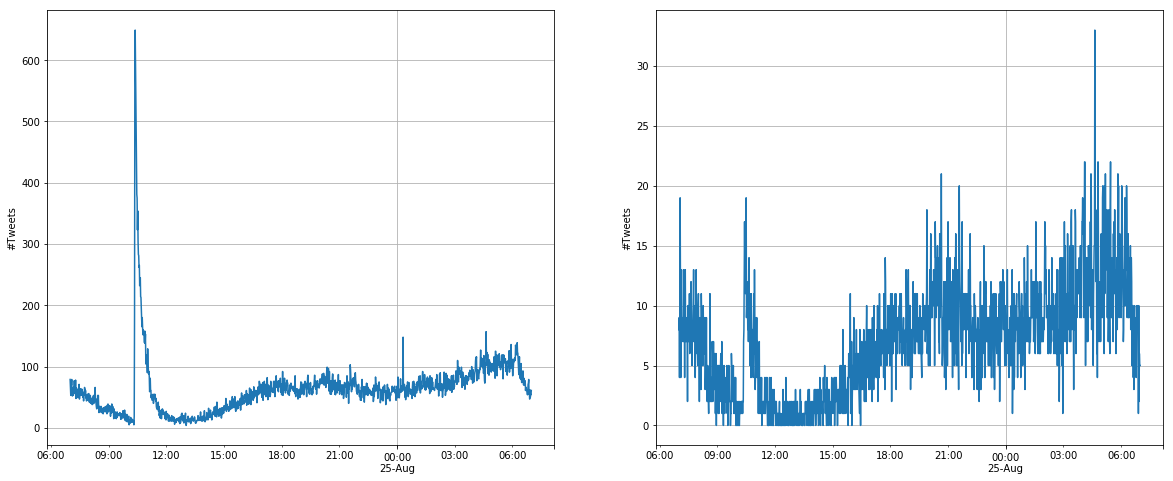

In [241]:
figure, axes = plt.subplots(1, 2,figsize=(20,8))


df_sum = df['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[0])
axes[0].grid()
axes[0].set_ylabel("#Tweets")

df_topic = df.loc[df['topics'] == 6]
df_sum = df_topic['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[1])
axes[1].grid()
axes[1].set_ylabel("#Tweets")

## Check geospatial distribution

In [222]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [223]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

df['count'] = 1
base_map = generateBaseMap([y,x],8)
HeatMap(data=df[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
display(base_map)

In [224]:
topic_numbers = [4,8]
base_maps = []
for topic_number in topic_numbers:
    df_topic = df.loc[df['topics'] == topic_number]
    base_map = generateBaseMap([y,x],8)
    HeatMap(data=df_topic[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
    base_maps.append(base_map)

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(base_maps[0].get_root().render().replace('"', '&quot;'),500,500,
                   base_maps[1].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

More information

* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Combining machine-learning topic models and spatiotemporal analysis of social media data for disaster footprint and damage assessment](https://www.tandfonline.com/doi/full/10.1080/15230406.2017.1356242)
* [Gensim](https://radimrehurek.com/gensim/)